In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
%matplotlib inline
import numpy as np

Function por stablishing the seed for reproducibility

In [3]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
path = Path("../datasets/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [5]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace(".png",".tif"))

Aux function for splitting between training and testing

In [6]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [7]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['Tumor']

def tumour(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

{'NoTumor': 0, 'Tumor': 1}


Early Stopping parameters

In [8]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=2

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [10]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [11]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 1
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

# UNet

## Manual Annotations

In [12]:
manual_name="manual"

In [13]:
path_manual_img = path_images/manual_name
path_manual_lbl = path_labels/manual_name

../datasets/Images/manual/341.png


<AxesSubplot:>

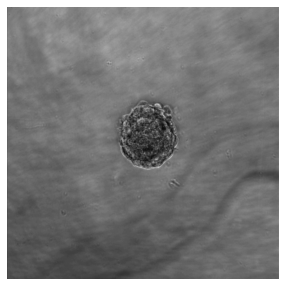

In [14]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [15]:
print(get_y_fn(img_f))

../datasets/Labels/manual/341.tif


<AxesSubplot:>

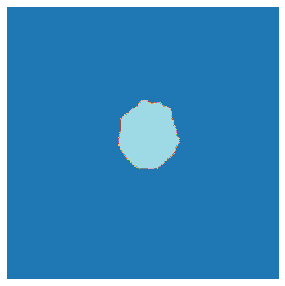

In [16]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [17]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


In [18]:
size = 1002
bs = 2

### No Data Augmentation

#### Selección de hiperparámetros

In UNet we are going to adjust weight decay.

Setting-up type transforms pipelines
Found 621 items
2 datasets of sizes 559,62
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying <lambda> gives
      ../datasets/Labels/manual/165.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'me

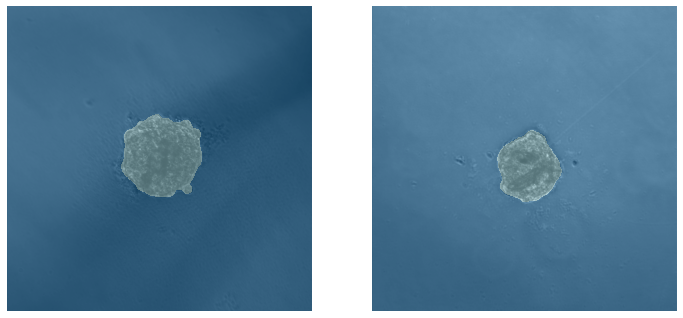

In [19]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-2

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

Recorder

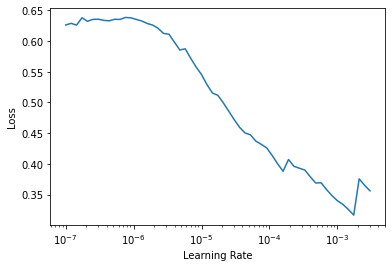

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.086248,0.037911,0.988823,0.930034,0.869219,02:21
1,0.066626,0.033672,0.990034,0.931653,0.872051,02:19
2,0.040510,0.019790,0.994375,0.954974,0.913827,02:19
3,0.034326,0.026325,0.996117,0.949326,0.903540,02:19
4,0.038544,0.019366,0.993579,0.953890,0.911845,02:19
5,0.021170,0.018740,0.994959,0.955474,0.914745,02:19
6,0.021630,0.016601,0.995787,0.960109,0.923279,02:24
7,0.013727,0.020907,0.996470,0.953452,0.911045,02:20
8,0.014717,0.017622,0.996679,0.960415,0.923844,02:26


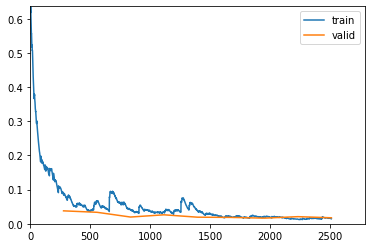

No improvement since epoch 6: early stopping


In [24]:
fname="unet-manual-no-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-5,1e-4),cbs=callbacksFitBeforeUnfreeze)

Recorder

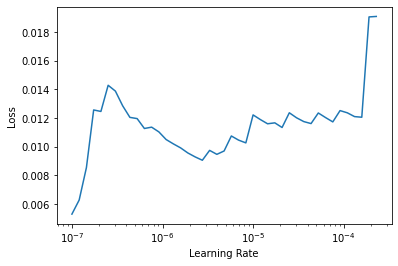

In [21]:
learn.load("unet-manual-no-data-augmentation-before-unfreeze-WD-2-best")
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.019560,0.020773,0.996185,0.941127,0.888801,02:24
1,0.020282,0.021562,0.996091,0.941298,0.889105,02:24
2,0.013953,0.020148,0.995906,0.945899,0.897352,02:25
3,0.015483,0.019686,0.995959,0.946362,0.898185,02:25
4,0.016780,0.019672,0.995649,0.946215,0.897921,02:25
5,0.013995,0.017717,0.995928,0.954483,0.912930,02:27
6,0.015620,0.016006,0.995615,0.962774,0.928221,02:26
7,0.014047,0.019386,0.995872,0.947535,0.900300,02:27
8,0.016156,0.018998,0.996448,0.953000,0.910220,02:25


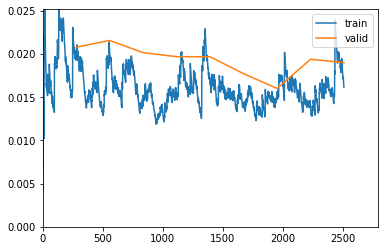

No improvement since epoch 6: early stopping


In [22]:
fname="unet-manual-no-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-1,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

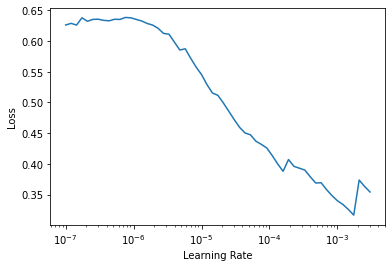

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.104897,0.033002,0.995810,0.936236,0.880117,02:18
1,0.111594,0.121999,0.954348,0.776074,0.634086,02:19
2,0.033498,0.020185,0.995349,0.956199,0.916074,02:22
3,0.035527,0.026571,0.996720,0.949009,0.902966,02:21
4,0.101610,0.027026,0.988757,0.932283,0.873156,02:19


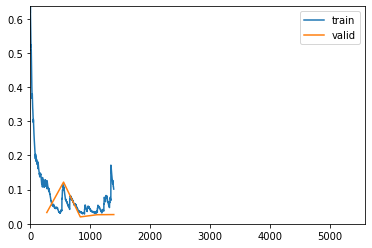

No improvement since epoch 2: early stopping


In [24]:
fname="unet-manual-no-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-5,1e-4),cbs=callbacksFitBeforeUnfreeze)

Recorder

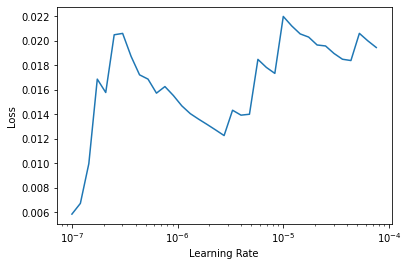

In [21]:
learn.load("unet-manual-no-data-augmentation-before-unfreeze-WD-1-best")
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.050340,0.020187,0.995402,0.956354,0.916359,02:26
1,0.047642,0.020252,0.995089,0.955665,0.915095,02:25
2,0.022326,0.019983,0.995125,0.956130,0.915947,02:25
3,0.029853,0.019616,0.994717,0.955798,0.915339,02:25
4,0.038271,0.020371,0.993410,0.952194,0.908751,02:26
5,0.024092,0.019335,0.994165,0.954913,0.913717,02:26
6,0.031030,0.019158,0.994145,0.955152,0.914154,02:27
7,0.022465,0.019738,0.993869,0.953783,0.911648,02:26
8,0.030857,0.021306,0.993197,0.950447,0.905573,02:26


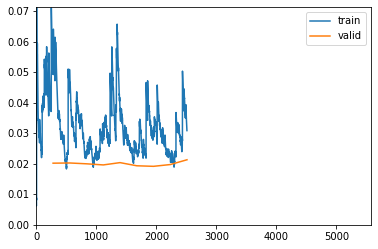

No improvement since epoch 6: early stopping


In [22]:
fname="unet-manual-no-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 987 items
2 datasets of sizes 621,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying <lambda> gives
      ../datasets/Labels/manual/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'m

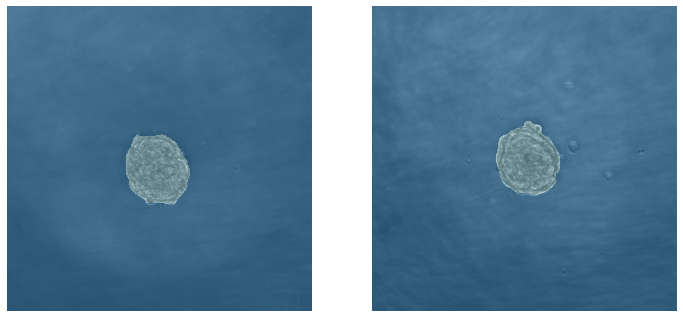

In [19]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name,test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

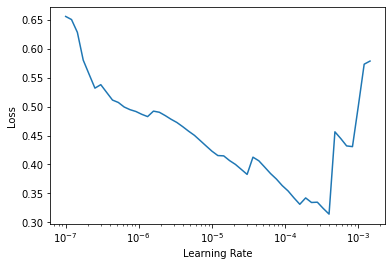

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.214531,0.192810,0.990447,0.609791,0.438633,02:58
1,0.057733,0.097961,0.978528,0.838706,0.722217,02:59
2,0.047306,0.078437,0.975194,0.867916,0.766653,02:59
3,0.052988,0.079459,0.969986,0.866089,0.763807,02:59
4,0.038696,0.057771,0.985535,0.899919,0.818048,02:59
5,0.030065,0.062314,0.981313,0.895801,0.811268,02:59
6,0.018265,0.077542,0.971992,0.868782,0.768006,03:00


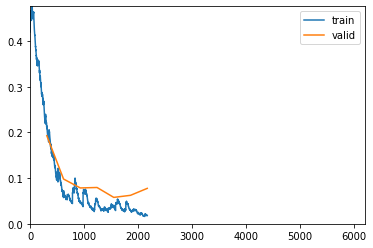

No improvement since epoch 4: early stopping


In [22]:
fname="unet-manual-no-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-6,1e-5),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("unet-manual-no-data-augmentation-before-unfreeze-best")
learn.validate()

(#4) [0.05777149647474289,0.9855348467826843,0.8999188663151468,0.8180477228081905]

Recorder

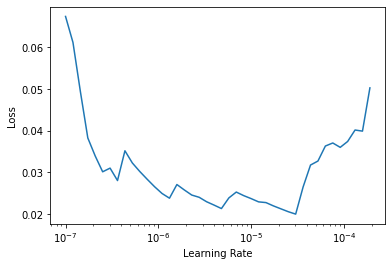

In [20]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.019418,0.054837,0.984533,0.904170,0.825101,03:02
1,0.022570,0.080570,0.986008,0.890593,0.802765,03:03
2,0.024987,0.065192,0.984491,0.911780,0.837864,03:03
3,0.012223,0.059689,0.994770,0.937265,0.881937,03:06
4,0.010591,0.085350,0.996942,0.903558,0.824081,03:04
5,0.007839,0.070378,0.986947,0.923965,0.858676,03:04


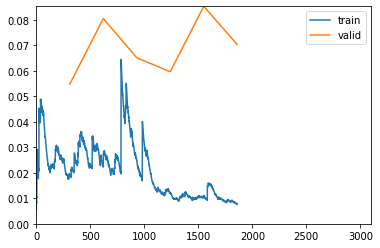

No improvement since epoch 3: early stopping


In [21]:
fname="unet-manual-no-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-5,0.6e-4),cbs=callbacksFitAfterUnfreeze)

In [21]:
learn.load("unet-manual-no-data-augmentation-after-unfreeze-best")
learn.validate()

(#4) [0.05968919396400452,0.994770348072052,0.9372650639858451,0.8819368143679445]

In [22]:
aux=learn.model
aux=aux.cpu()

import torchvision.transforms as transforms
img = PILImage.create("../datasets/Images/manual/2.png")
transformer=transforms.Compose([transforms.Resize((1002,1002)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("TorchScript models/unet-dataset1-no-data-augmentation.pth")

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/fastai2/vision/models/unet.py:38: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if ssh != up_out.shape[-2:]:
/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/fastai2/vision/models/unet.py:48: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.orig.shape[-2:] != x.shape[-2:]:


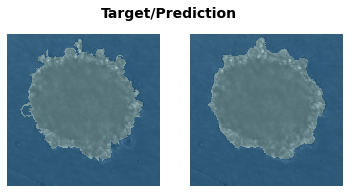

In [23]:
learn.show_results(vmin=0,vmax=1) # show results

### Data Augmentation

Setting-up type transforms pipelines
Found 621 items
2 datasets of sizes 559,62
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying <lambda> gives
      ../datasets/Labels/manual/165.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255

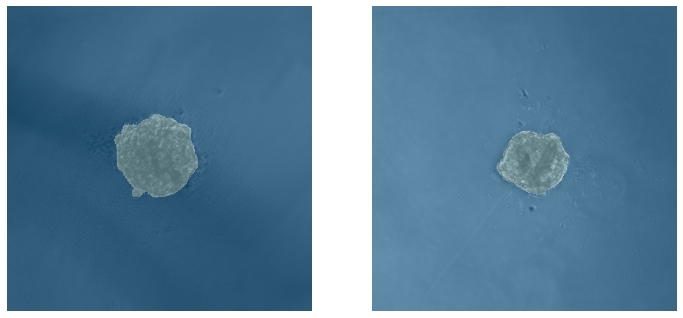

In [19]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-3

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-3,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

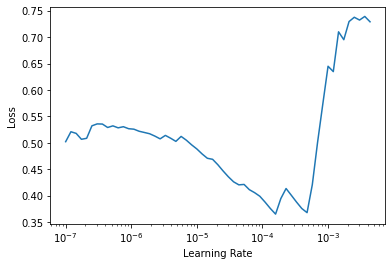

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.093238,0.037150,0.989128,0.931088,0.871062,02:35
1,0.083558,0.033026,0.994581,0.944226,0.894345,02:35
2,0.038715,0.021757,0.992214,0.948143,0.901399,02:35
3,0.036166,0.021573,0.996224,0.954267,0.912534,02:36
4,0.031508,0.026010,0.993540,0.942033,0.890417,02:35
5,0.018144,0.020004,0.994749,0.954716,0.913355,02:36
6,0.022247,0.015597,0.996916,0.962170,0.927098,02:35
7,0.013161,0.021840,0.996110,0.953016,0.910248,02:36
8,0.013879,0.018627,0.995903,0.957691,0.918816,02:36


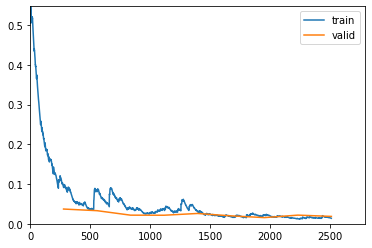

No improvement since epoch 6: early stopping


In [22]:
fname="unet-manual-data-augmentation-before-unfreeze-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-5,1e-4),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("unet-manual-data-augmentation-before-unfreeze-WD-3-best")
learn.validate()

(#4) [0.015597433783113956,0.9969157576560974,0.9621703001192443,0.9270984442146872]

Recorder

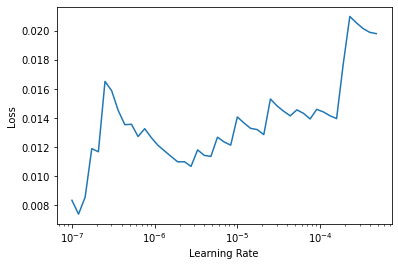

In [22]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.016669,0.017889,0.995965,0.953704,0.911505,02:29
1,0.018198,0.019782,0.995646,0.948612,0.902248,02:28
2,0.013079,0.019741,0.996337,0.951095,0.906750,02:28


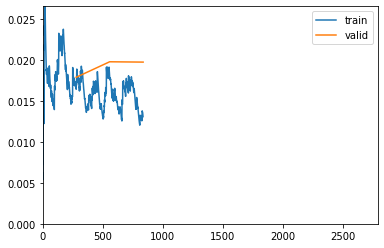

No improvement since epoch 0: early stopping


In [23]:
fname="unet-manual-data-augmentation-after-unfreeze-WD-3-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-2

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

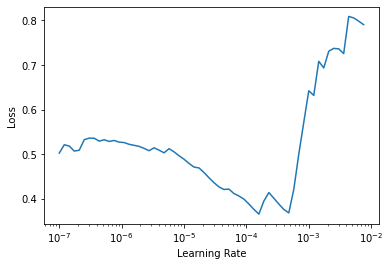

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.093110,0.038107,0.988787,0.929714,0.868659,02:19
1,0.083756,0.036910,0.993737,0.937150,0.881734,02:19
2,0.037914,0.021656,0.992100,0.947702,0.900602,02:19
3,0.032666,0.020440,0.996398,0.955048,0.913963,02:19
4,0.033301,0.029118,0.992795,0.940725,0.888084,02:20
5,0.018154,0.021679,0.994939,0.951046,0.906662,02:19


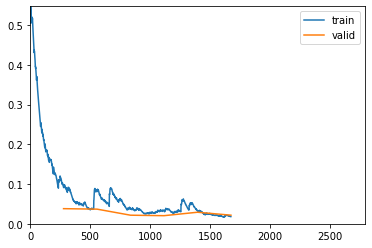

No improvement since epoch 3: early stopping


In [22]:
fname="unet-manual-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-5,1e-4),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("unet-manual-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

(#4) [0.02043999172747135,0.9963976144790649,0.9550476618103917,0.9139628927621928]

Recorder

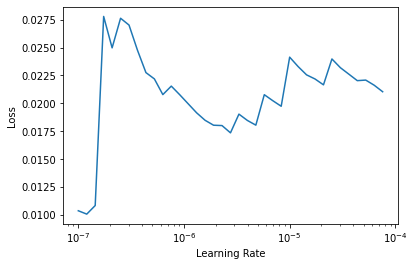

In [22]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.031057,0.018618,0.995248,0.956911,0.917382,02:25
1,0.029949,0.018731,0.993811,0.954514,0.912985,02:25
2,0.018056,0.017200,0.995069,0.957778,0.918978,02:25
3,0.020000,0.017549,0.994809,0.955125,0.914105,02:25
4,0.022291,0.021622,0.993082,0.949701,0.904219,02:27


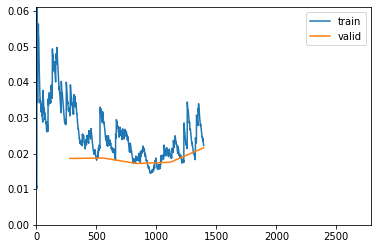

No improvement since epoch 2: early stopping


In [23]:
fname="unet-manual-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(4e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-1,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

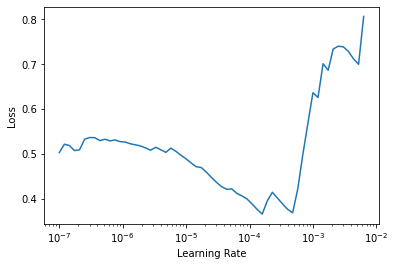

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.093718,0.039225,0.988407,0.928075,0.865802,02:19
1,0.082544,0.035913,0.994005,0.940570,0.887808,02:19
2,0.048770,0.029101,0.988998,0.933472,0.875244,02:20
3,0.030765,0.020376,0.996166,0.955501,0.914794,02:20
4,0.036549,0.020682,0.993048,0.949341,0.903567,02:20
5,0.019371,0.018621,0.994582,0.957357,0.918203,02:19
6,0.023040,0.015964,0.996805,0.962874,0.928405,02:20
7,0.013420,0.019017,0.996137,0.956696,0.916986,02:20
8,0.014486,0.017896,0.995799,0.959747,0.922609,02:20


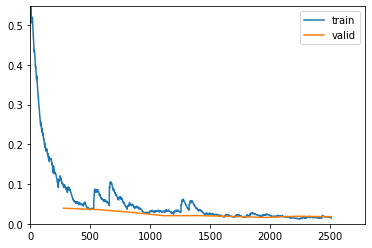

No improvement since epoch 6: early stopping


In [22]:
fname="unet-manual-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-5,1e-4),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("unet-manual-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

(#4) [0.01596418209373951,0.9968048930168152,0.9628736682169647,0.9284053819765479]

Recorder

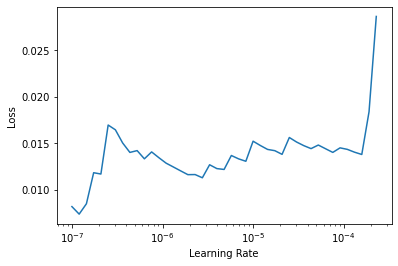

In [22]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.017600,0.017605,0.995813,0.956622,0.916850,02:25
1,0.018798,0.018635,0.995503,0.953662,0.911429,02:26
2,0.013439,0.018202,0.996321,0.953792,0.911666,02:25


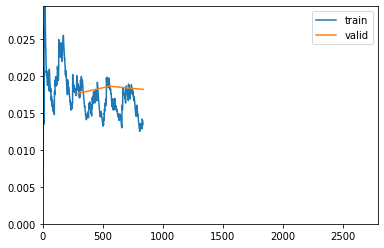

No improvement since epoch 0: early stopping


In [23]:
fname="unet-manual-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(4e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

####  Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 987 items
2 datasets of sizes 621,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying <lambda> gives
      ../datasets/Labels/manual/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 25

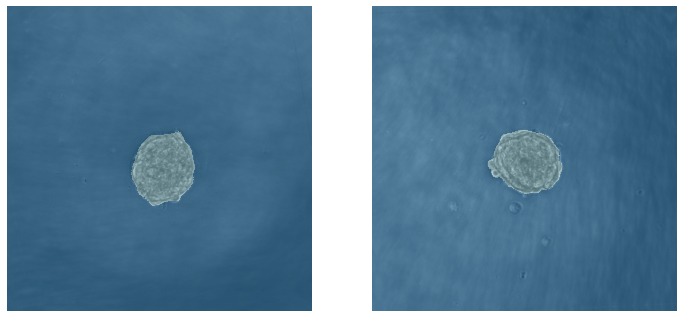

In [19]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name,test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

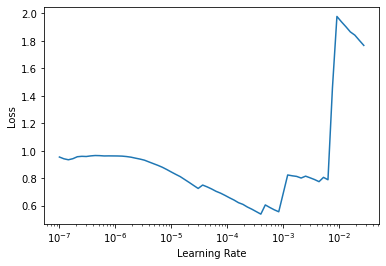

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.958729,0.914454,0.114930,0.141774,0.076296,02:57
1,0.936782,0.880628,0.160714,0.139717,0.075105,02:58
2,0.943913,0.886133,0.154408,0.143984,0.077577,03:01
3,0.941433,0.903242,0.130403,0.141840,0.076333,03:01
4,0.938013,0.873965,0.154827,0.152834,0.082739,02:59
5,0.937218,0.900611,0.121819,0.139136,0.074769,02:59
6,0.936189,0.877462,0.164558,0.143330,0.077197,02:59


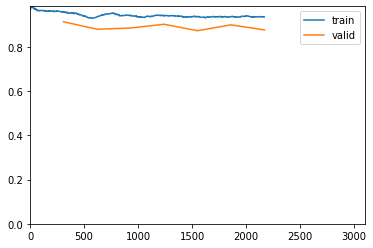

No improvement since epoch 4: early stopping


In [22]:
fname="unet-manual-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-5,2e-4),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("unet-manual-data-augmentation-before-unfreeze-best")
learn.validate()

(#4) [0.8739651441574097,0.15482665598392487,0.15283355777538135,0.08273946206564774]

Recorder

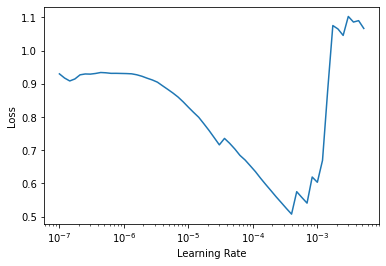

In [22]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.031172,0.063764,0.989793,0.902046,0.821569,03:05
1,0.068407,0.214840,0.994738,0.848211,0.736428,03:05
2,0.036781,0.051433,0.982707,0.906849,0.829574,03:05
3,0.022995,0.069681,0.986256,0.920546,0.852788,03:05
4,0.020939,0.044662,0.989635,0.933372,0.875067,03:05
5,0.010384,0.033456,0.992264,0.942923,0.892010,03:05
6,0.009063,0.041354,0.996706,0.914927,0.843194,03:06
7,0.009784,0.027337,0.994552,0.954207,0.912424,03:06
8,0.010408,0.025225,0.995516,0.958856,0.920965,03:27
9,0.008490,0.031252,0.995927,0.937654,0.882626,03:27


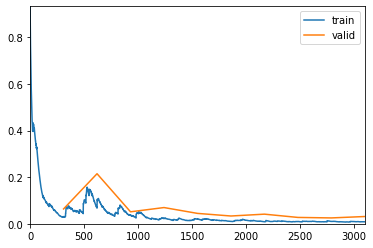

In [23]:
fname="unet-manual-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-5,2e-4),cbs=callbacksFitAfterUnfreeze)

In [21]:
learn.load("unet-manual-data-augmentation-after-unfreeze-best")
learn.validate()

(#4) [0.025225089862942696,0.995515763759613,0.9588564014666148,0.9209646035545098]

In [22]:
aux=learn.model
aux=aux.cpu()

import torchvision.transforms as transforms
img = PILImage.create("../datasets/Images/manual/2.png")
transformer=transforms.Compose([transforms.Resize((1002,1002)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("TorchScript models/unet-dataset1-data-augmentation.pth")

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/fastai/vision/models/unet.py:38: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if ssh != up_out.shape[-2:]:
/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/fastai/vision/models/unet.py:48: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.orig.shape[-2:] != x.shape[-2:]:


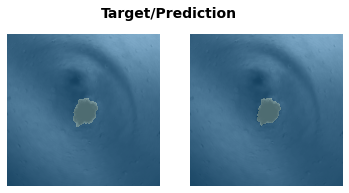

In [22]:
learn.show_results(vmin=0,vmax=1) # show results

## Manual + SpheroidJ Annotations

In [12]:
manual_spheroidj_name = "manual + spheroidj"

In [13]:
path_manual_plus_spheroidj_clear_img = path_images/manual_spheroidj_name
path_manual_plus_spheroidj_clear_lbl = path_labels/manual_spheroidj_name

../datasets/Images/manual + spheroidj/805.png


<AxesSubplot:>

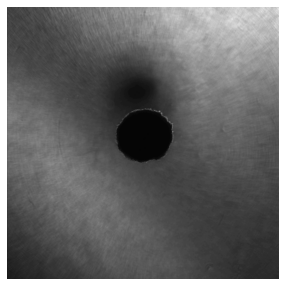

In [14]:
fnames_manual_plus_spheroidj_clear = get_image_files(path_manual_plus_spheroidj_clear_img)
lbl_names_manual_plus_spheroidj_clear = get_image_files(path_manual_plus_spheroidj_clear_lbl)

# open and show image
img_f = fnames_manual_plus_spheroidj_clear[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [15]:
print(get_y_fn(img_f))

../datasets/Labels/manual + spheroidj/805.tif


<AxesSubplot:>

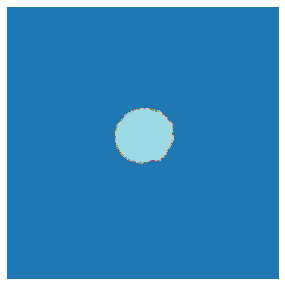

In [16]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [17]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


In [18]:
size = 1002
bs = 2

### No Data Augmentation

Setting-up type transforms pipelines
Found 1069 items
2 datasets of sizes 963,106
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/42.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 

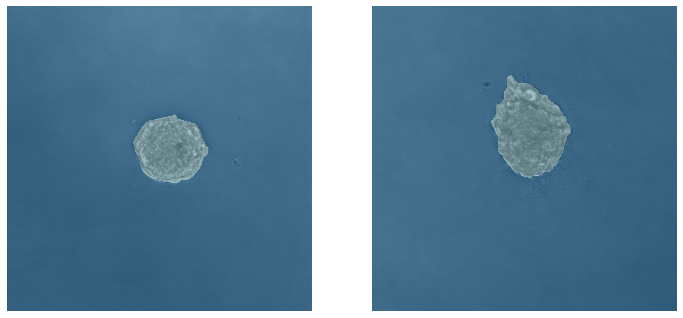

In [19]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_spheroidj_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-3

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-3,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

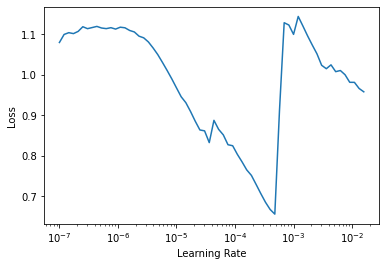

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.084049,0.100219,0.951087,0.825592,0.702986,03:56
1,0.050316,0.047774,0.988781,0.924171,0.859031,03:57
2,0.056984,0.068993,0.966698,0.872785,0.774284,03:57
3,0.059784,0.058742,0.976165,0.903466,0.823930,03:57


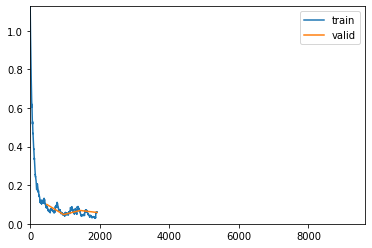

No improvement since epoch 1: early stopping


In [22]:
fname="unet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-5,1e-4),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("unet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-3-best")
learn.validate()

(#4) [0.04777375981211662,0.9887809157371521,0.9241706284354033,0.859030858296206]

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.03981071710586548)


Recorder

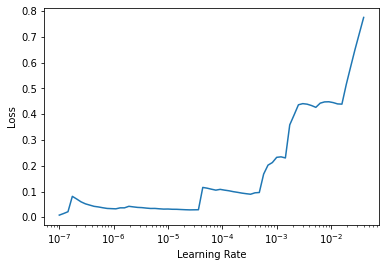

In [22]:
learn.unfreeze()
print(learn.lr_find(stop_div=False)) # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.069755,0.053837,0.985334,0.909576,0.834148,04:07
1,0.049874,0.047415,0.989040,0.924371,0.859376,04:08
2,0.083395,0.047958,0.987803,0.923276,0.857486,04:08
3,0.088701,0.043056,0.991406,0.933305,0.874951,04:08
4,0.066446,0.048667,0.989640,0.921401,0.854258,04:08
5,0.115045,0.044747,0.994386,0.929594,0.868451,04:09


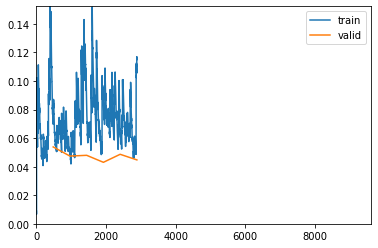

No improvement since epoch 3: early stopping


In [23]:
fname="unet-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-3-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-2

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

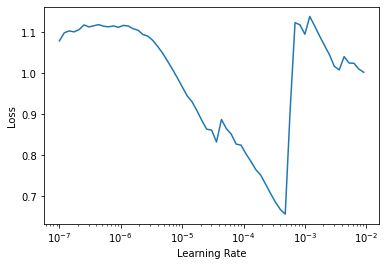

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.084194,0.100235,0.951023,0.825502,0.702856,04:03
1,0.050296,0.047691,0.988648,0.924421,0.859464,04:00
2,0.056146,0.069821,0.966814,0.874127,0.776399,04:00
3,0.064149,0.080490,0.961017,0.857998,0.751311,04:00


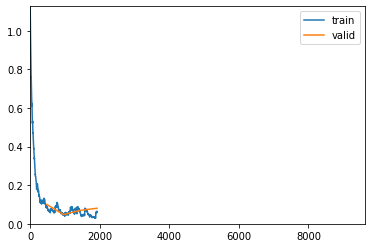

No improvement since epoch 1: early stopping


In [22]:
fname="unet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-5,1e-4),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("unet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

(#4) [0.047690507024526596,0.9886480569839478,0.9244212446622007,0.8594640235078594]

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.033113110810518265)


Recorder

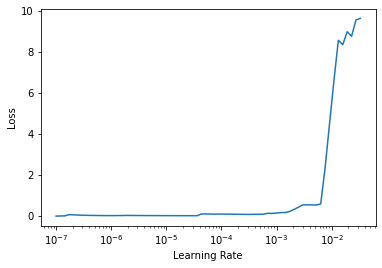

In [23]:
learn.unfreeze()
print(learn.lr_find(stop_div=False)) # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.069775,0.053755,0.985091,0.909688,0.834337,04:13
1,0.049806,0.047320,0.988907,0.924634,0.859831,04:12
2,0.083570,0.047846,0.987615,0.923484,0.857845,04:11
3,0.088857,0.042916,0.991364,0.933533,0.875351,04:10
4,0.066500,0.048497,0.989488,0.921986,0.855263,04:10
5,0.115215,0.044641,0.994384,0.929749,0.868721,04:12


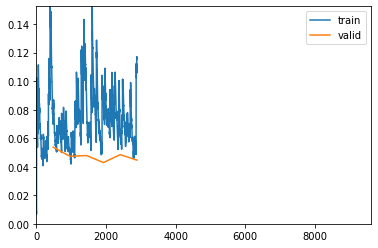

No improvement since epoch 3: early stopping


In [24]:
fname="unet-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-7,0.3e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-1,
                                 pretrained=True, normalize=True).to_fp16()

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.033113110810518265)


Recorder

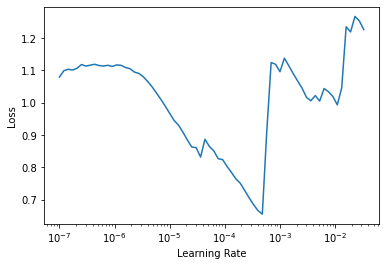

In [21]:
print(learn.lr_find()) # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,1.081017,0.992362,0.129446,0.093620,0.049109,04:01
1,1.057353,1.004989,0.110967,0.092482,0.048483,04:17
2,1.024185,0.976613,0.131562,0.084648,0.044195,04:07
3,0.969494,0.932190,0.113615,0.091614,0.048006,04:13
4,0.924251,0.884646,0.158781,0.077446,0.040283,04:09
5,0.883234,0.888015,0.090246,0.090662,0.047484,04:05
6,0.850709,0.832885,0.173886,0.071128,0.036875,04:05
7,0.826094,0.807762,0.200151,0.067588,0.034976,04:04
8,0.808397,0.794471,0.241560,0.058905,0.030346,04:03
9,0.796344,0.784543,0.219265,0.064371,0.033256,04:06


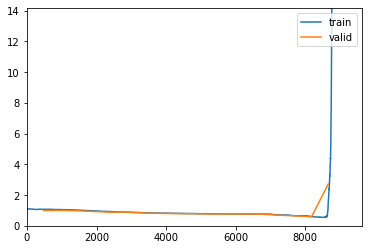

No improvement since epoch 16: early stopping


In [22]:
fname="unet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-5,3e-4),cbs=callbacksFitBeforeUnfreeze)

Recorder

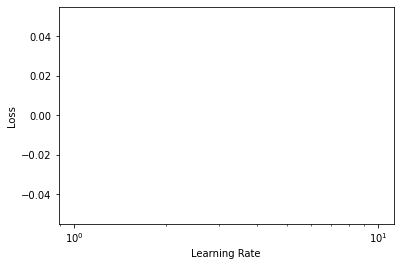

In [40]:
learn.load("unet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-1-best")
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 1435 items
2 datasets of sizes 1069,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255

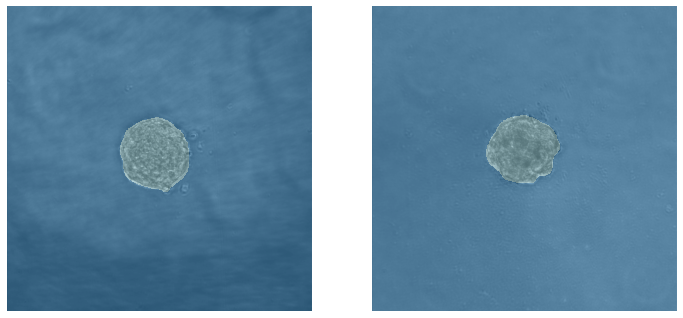

In [19]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                                     get_items=partial(get_image_files,folders=[manual_spheroidj_name,test_name]),
                                     get_y=get_y_fn,
                                     splitter=FuncSplitter(ParentSplitter),
                                     item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                                     batch_tfms=Normalize.from_stats(*imagenet_stats)
                          )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

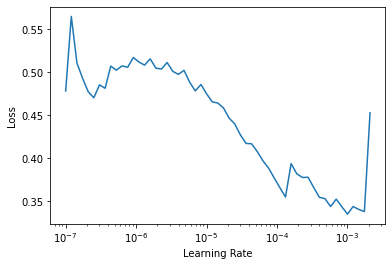

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.083515,0.081520,0.968633,0.878018,0.782561,04:43
1,0.063669,0.091780,0.960211,0.850298,0.739581,04:43
2,0.056639,0.063886,0.972821,0.886497,0.796133,04:44
3,0.063664,0.045605,0.991750,0.926598,0.863235,04:45
4,0.026358,0.039624,0.985801,0.932382,0.873329,04:45
5,0.022523,0.042356,0.988670,0.935212,0.878309,04:45
6,0.028517,0.040646,0.985632,0.928789,0.867046,04:45
7,0.017820,0.054135,0.989285,0.902118,0.821690,04:45


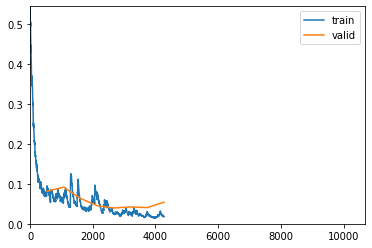

No improvement since epoch 5: early stopping


In [22]:
fname="unet-manual-spheroidj-no-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-5,1e-4),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("unet-manual-spheroidj-no-data-augmentation-before-unfreeze-best")
learn.validate()

(#4) [0.04235587269067764,0.9886699914932251,0.9352122312793637,0.8783085782465738]

Recorder

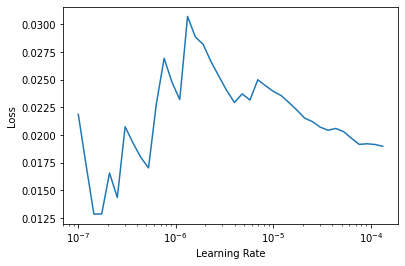

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.022858,0.033336,0.991139,0.943513,0.893067,04:54
1,0.016239,0.054092,0.985550,0.927474,0.864757,04:55
2,0.020133,0.026768,0.990893,0.951581,0.907635,04:56
3,0.016316,0.028103,0.992210,0.953460,0.911060,04:56
4,0.014561,0.031984,0.997274,0.955826,0.915389,04:57
5,0.010511,0.022363,0.994243,0.964899,0.932178,04:56
6,0.010261,0.021706,0.996797,0.966105,0.934432,04:56
7,0.009110,0.019628,0.997185,0.970719,0.943104,04:57
8,0.008015,0.020419,0.996303,0.969977,0.941705,04:58
9,0.008099,0.020777,0.996248,0.969202,0.940244,04:58


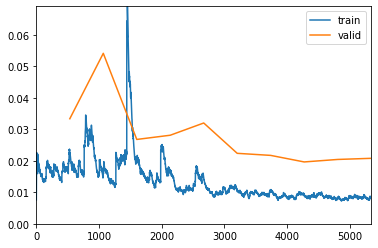

No improvement since epoch 7: early stopping


In [25]:
fname="unet-manual-spheroidj-no-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-5,1e-4),cbs=callbacksFitAfterUnfreeze)

In [21]:
learn.load("unet-manual-spheroidj-no-data-augmentation-after-unfreeze-best")
learn.validate()

(#4) [0.019628170877695084,0.9971848726272583,0.9707188530155066,0.9431036950977313]

In [21]:
aux=learn.model
aux=aux.cpu()

import torchvision.transforms as transforms
img = PILImage.create("../datasets/Images/manual/2.png")
transformer=transforms.Compose([transforms.Resize((1002,1002)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("TorchScript models/unet-dataset3-no-data-augmentation.pth")

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/fastai2/vision/models/unet.py:38: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if ssh != up_out.shape[-2:]:
/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/fastai2/vision/models/unet.py:48: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.orig.shape[-2:] != x.shape[-2:]:


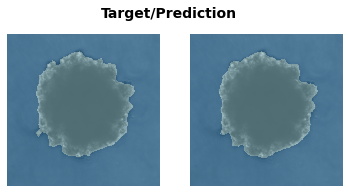

In [29]:
learn.show_results(vmin=0,vmax=1) # show results

### DataAugmentation

Setting-up type transforms pipelines
Found 1069 items
2 datasets of sizes 963,106
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/42.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeli

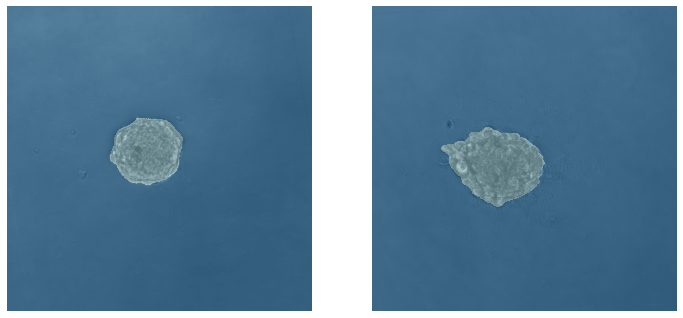

In [19]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_spheroidj_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-3

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-3,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

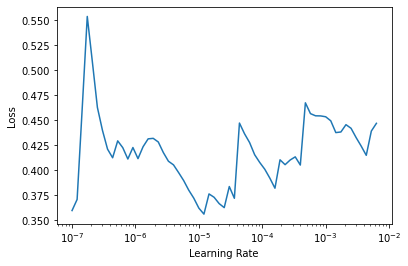

In [20]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.125904,0.107265,0.966765,0.829842,0.709171,04:29
1,0.057455,0.051589,0.984023,0.917666,0.847858,04:29
2,0.057447,0.056579,0.978456,0.906724,0.829365,04:29
3,0.053325,0.052996,0.977410,0.909970,0.834812,04:29


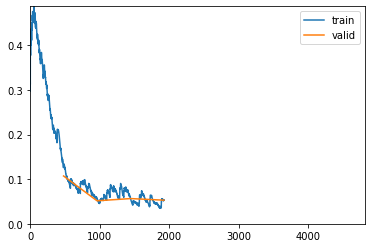

No improvement since epoch 1: early stopping


In [21]:
fname="unet-manual-spheroidj-data-augmentation-before-unfreeze-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-6,1e-5),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("unet-manual-spheroidj-data-augmentation-before-unfreeze-WD-3-best")
learn.validate()

(#4) [0.051588863134384155,0.9840225577354431,0.9176657448554677,0.8478579888732478]

Recorder

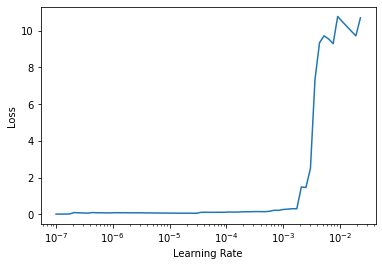

In [22]:
learn.unfreeze()
learn.lr_find(stop_div=False) # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.047519,0.051589,0.984021,0.917664,0.847855,04:40
1,0.068943,0.050744,0.984721,0.918892,0.849954,04:42
2,0.080791,0.045074,0.989101,0.930981,0.870874,04:42
3,0.061480,0.049611,0.986708,0.923334,0.857587,04:42
4,0.094986,0.047458,0.992024,0.924154,0.859002,04:42


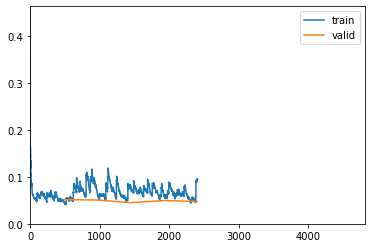

No improvement since epoch 2: early stopping


In [23]:
fname="unet-manual-spheroidj-data-augmentation-after-unfreeze-WD-3-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-7,1e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-2

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

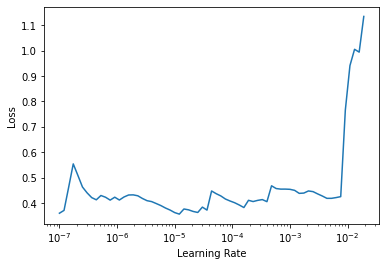

In [20]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.126533,0.107588,0.966753,0.829662,0.708909,04:28
1,0.057587,0.051743,0.983983,0.917436,0.847466,04:29
2,0.057442,0.056593,0.978467,0.906790,0.829474,04:29
3,0.053381,0.053096,0.977371,0.909817,0.834554,04:29


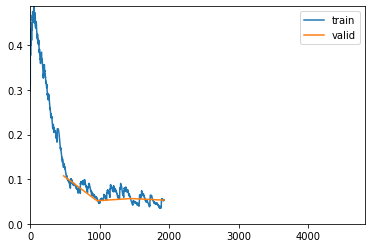

No improvement since epoch 1: early stopping


In [21]:
fname="unet-manual-spheroidj-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-6,1e-5),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("unet-manual-spheroidj-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

(#4) [0.05174320936203003,0.9839834570884705,0.917435878403202,0.8474656236066372]

Recorder

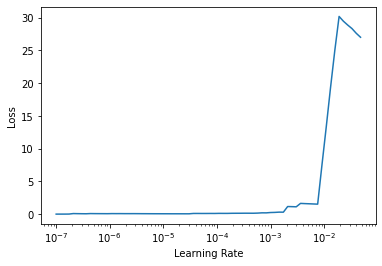

In [22]:
learn.unfreeze()
learn.lr_find(stop_div=False) # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.047564,0.051743,0.983984,0.917439,0.847471,04:42
1,0.068902,0.050880,0.984698,0.918783,0.849767,04:42
2,0.080722,0.045216,0.989109,0.930896,0.870725,04:42
3,0.061525,0.049722,0.986723,0.923255,0.857449,04:43
4,0.094817,0.047631,0.992021,0.923905,0.858573,04:42


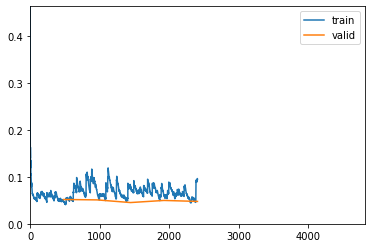

No improvement since epoch 2: early stopping


In [23]:
fname="unet-manual-spheroidj-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-7,1e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-1,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

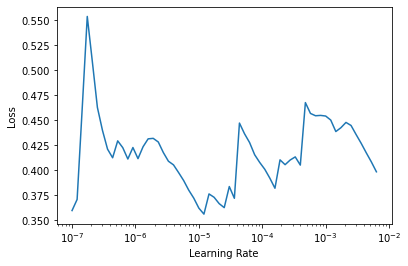

In [20]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.125581,0.107100,0.966756,0.830000,0.709402,04:27
1,0.057452,0.051596,0.984006,0.917604,0.847753,04:29
2,0.057296,0.056361,0.978539,0.907063,0.829932,04:29
3,0.053094,0.052969,0.977407,0.910025,0.834905,04:29


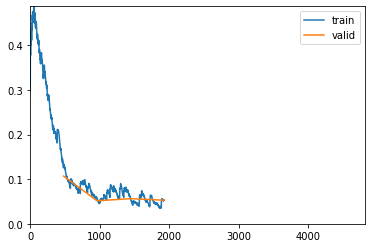

No improvement since epoch 1: early stopping


In [21]:
fname="unet-manual-spheroidj-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-6,1e-5),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("unet-manual-spheroidj-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

(#4) [0.051596302539110184,0.9840062856674194,0.9176040612695419,0.8477526831316453]

Recorder

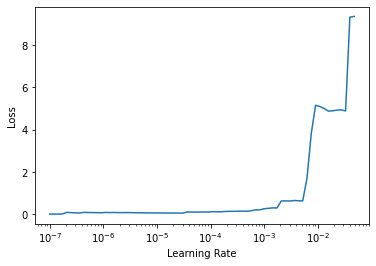

In [22]:
learn.unfreeze()
learn.lr_find(stop_div=False) # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.047564,0.051599,0.984004,0.917596,0.847739,04:41
1,0.068982,0.050733,0.984725,0.918861,0.849900,04:43
2,0.080791,0.045066,0.989113,0.931053,0.871001,04:42
3,0.061450,0.049560,0.986732,0.923402,0.857703,04:42
4,0.095003,0.047486,0.992036,0.924087,0.858886,04:43


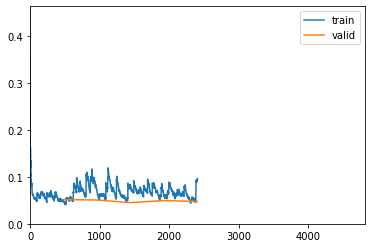

No improvement since epoch 2: early stopping


In [23]:
fname="unet-manual-spheroidj-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-7,1e-6),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 1435 items
2 datasets of sizes 1069,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pi

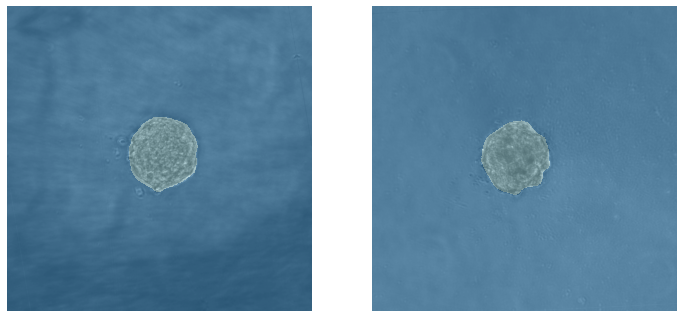

In [19]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_spheroidj_name,test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 pretrained=True, normalize=True).to_fp16()

Recorder

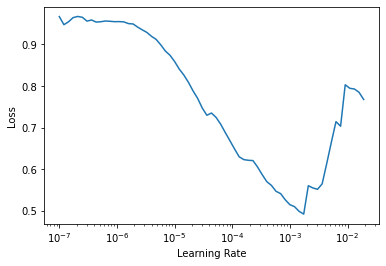

In [20]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.105676,0.086110,0.967300,0.872125,0.773246,05:18
1,0.228062,0.166048,0.933479,0.775632,0.633496,05:17
2,0.063691,0.057685,0.974817,0.889565,0.801096,05:17
3,0.083891,0.067327,0.989810,0.907475,0.830623,05:17
4,0.050986,0.048187,0.984832,0.914227,0.842006,05:16
5,0.044863,0.051387,0.981186,0.913399,0.840601,05:17
6,0.040823,0.045164,0.985963,0.921899,0.855114,05:16
7,0.037821,0.041076,0.989704,0.925886,0.862000,05:17
8,0.041637,0.039320,0.988620,0.931768,0.872253,05:17
9,0.043192,0.041651,0.987479,0.928364,0.866305,05:17


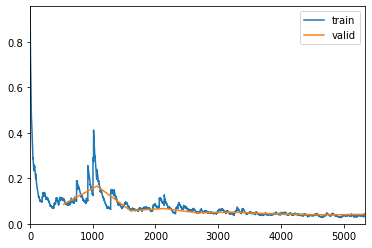

In [21]:
fname="unet-manual-spheroidj-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [20]:
learn.load("unet-manual-spheroidj-data-augmentation-before-unfreeze-best")
learn.validate()

(#4) [0.03931961581110954,0.988619863986969,0.9317684587381625,0.8722532735155157]

Recorder

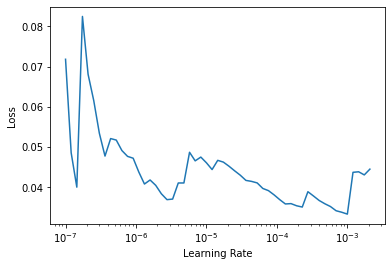

In [21]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.035150,0.040911,0.987605,0.928216,0.866048,05:32
1,0.030282,0.039794,0.988436,0.931987,0.872637,05:32
2,0.025950,0.035991,0.989722,0.941140,0.888823,05:33
3,0.029980,0.029458,0.992473,0.947416,0.900086,05:33
4,0.016933,0.017950,0.995627,0.967958,0.937906,05:32
5,0.015336,0.018039,0.994870,0.968828,0.939541,05:32
6,0.013397,0.017948,0.997791,0.967400,0.936858,05:32
7,0.011494,0.016670,0.995685,0.971572,0.944716,05:32
8,0.012697,0.015118,0.996473,0.972594,0.946650,05:32
9,0.012389,0.015846,0.996884,0.971490,0.944560,05:32


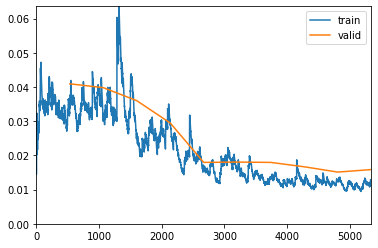

In [22]:
fname="unet-manual-spheroidj-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-5,1e-4),cbs=callbacksFitAfterUnfreeze)

In [21]:
learn.load("unet-manual-spheroidj-data-augmentation-after-unfreeze-best")
learn.validate()

(#4) [0.015118085779249668,0.9964731931686401,0.9725938500462052,0.946649823042178]

In [21]:
aux=learn.model
aux=aux.cpu()

import torchvision.transforms as transforms
img = PILImage.create("../datasets/Images/manual/2.png")
transformer=transforms.Compose([transforms.Resize((1002,1002)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("TorchScript models/unet-dataset3-data-augmentation.pth")

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/fastai2/vision/models/unet.py:38: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if ssh != up_out.shape[-2:]:
/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/fastai2/vision/models/unet.py:48: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.orig.shape[-2:] != x.shape[-2:]:


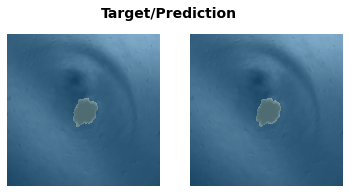

In [21]:
learn.show_results(vmin=0,vmax=1) # show results